In [22]:
import tensorflow as tf
import pandas as pd
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
from six.moves import cPickle as pickle
import os
import platform
from subprocess import check_output

%matplotlib inline

In [23]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == '2':
        return  pickle.load(f)
    elif version[0] == '3':
        return  pickle.load(f, encoding='latin1')
    raise ValueError("invalid python version: {}".format(version))

def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, 'rb') as f:
        datadict = load_pickle(f)
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
        Y = np.array(Y)
        return X, Y

def load_CIFAR10(ROOT):
    """ load all of cifar """
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte



def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    # Load the raw CIFAR-10 data
    cifar10_dir = '/home/nesma/Desktop/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)




Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


In [24]:
# define net
class CifarNet():
    def __init__(self):
        # conv layer
        # H2 = (H1 - F + 2P)/S +1
        # (32-5)/1 + 1 = 28
        # 28x28x32 = 25088
        # To ReLu (?x16x16x32) -> MaxPool (?x16x16x32) -> affine (8192)
        self.Wconv1 = tf.get_variable("Wconv1", shape=[5, 5, 3, 32])
        self.bconv1 = tf.get_variable("bconv1", shape=[32])
        # (32-5)/1 + 1 = 28
        # 28x28x64 = 50176
        self.Wconv2 = tf.get_variable("Wconv2", shape=[5, 5, 32, 64])
        self.bconv2 = tf.get_variable("bconv2", shape=[64])
        # affine layer with 1024
        self.W1 = tf.get_variable("W1", shape=[3136, 1024])
        self.b1 = tf.get_variable("b1", shape=[1024])
        # affine layer with 10
        self.W2 = tf.get_variable("W2", shape=[1024, 10])
        self.b2 = tf.get_variable("b2", shape=[10])        
        
    def forward(self, X, y, is_training):
        # conv2d
        # ReLu
        # conv2d
        # ReLu
        # maxpool
        # Batch Norm
        # Affine
        # Batch Norm
        # ReLu
        # Affine
        # dropout
        # Batch Norm

        # conv layer
        # H2 = (H1 - F + 2P)/S +1
        # (32-5)/1 + 1 = 28
        # 28x28x32 = 25088
        # To ReLu (?x16x16x32) -> MaxPool (?x16x16x32) -> affine (8192)

        # define our graph (e.g. two_layer_convnet) with stride 1
        conv1 = tf.nn.conv2d(X, self.Wconv1, strides=[1, 1, 1, 1], padding='SAME') + self.bconv1
        print(conv1.shape)
        # ReLU Activation Layer
        relu1 = tf.nn.relu(conv1)
        print(relu1)
        # Conv
        conv2 = tf.nn.conv2d(relu1, self.Wconv2, strides=[1, 2, 2, 1], padding='VALID') + self.bconv2
        print(conv2.shape)
        # ReLU Activation Layer
        relu2 = tf.nn.relu(conv2)
        print(relu2)
        # 2x2 Max Pooling layer with a stride of 2
        maxpool = tf.layers.max_pooling2d(relu2, pool_size=(2,2), strides=2)
        print(maxpool.shape)
        maxpool_flat = tf.reshape(maxpool,[-1,3136])
        # Spatial Batch Normalization Layer (trainable parameters, with scale and centering)
        bn1 = tf.layers.batch_normalization(inputs=maxpool_flat, center=True, scale=True, training=is_training)
        # Affine layer with 1024 output units
        affine1 = tf.matmul(bn1, self.W1) + self.b1
        print(affine1.shape)
        # vanilla batch normalization
        affine1_flat = tf.reshape(affine1,[-1,1024])
        bn2 = tf.layers.batch_normalization(inputs=affine1, center=True, scale=True, training=is_training)
        print(bn2.shape)
        # ReLU Activation Layer
        relu2 = tf.nn.relu(bn2)
        print(relu2.shape)
        # dropout
        drop1 = tf.layers.dropout(inputs=relu2, training=is_training)
        # Affine layer from 1024 input units to 10 outputs
        affine2 = tf.matmul(drop1, self.W2) + self.b2
        # vanilla batch normalization
        affine2_flat = tf.reshape(affine2,[-1,3136])
        self.predict = tf.layers.batch_normalization(inputs=affine2, center=True, scale=True, training=is_training)
        print(self.predict.shape)
        return self.predict
    
    def run(self, session, loss_val, Xd, yd,
                  epochs=1, batch_size=64, print_every=100,
                  training=None, plot_losses=False, isSoftMax=False):
        # have tensorflow compute accuracy
        if isSoftMax:
            correct_prediction = tf.nn.softmax(self.predict)
        else:
            correct_prediction = tf.equal(tf.argmax(self.predict,1), y)
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        # shuffle indicies
        train_indicies = np.arange(Xd.shape[0])
        np.random.shuffle(train_indicies)

        training_now = training is not None

        # setting up variables we want to compute (and optimizing)
        # if we have a training function, add that to things we compute
        variables = [mean_loss, correct_prediction, accuracy]
        if training_now:
            variables[-1] = training

        # counter 
        iter_cnt = 0
        for e in range(epochs):
            # keep track of losses and accuracy
            correct = 0
            losses = []
            # make sure we iterate over the dataset once
            for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
                # generate indicies for the batch
                start_idx = (i*batch_size)%Xd.shape[0]
                idx = train_indicies[start_idx:start_idx+batch_size]

                # create a feed dictionary for this batch
                feed_dict = {X: Xd[idx,:],
                             y: yd[idx],
                             is_training: training_now }
                # get batch size
                actual_batch_size = yd[idx].shape[0]

                # have tensorflow compute loss and correct predictions
                # and (if given) perform a training step
                loss, corr, _ = session.run(variables,feed_dict=feed_dict)

                # aggregate performance stats
                losses.append(loss*actual_batch_size)
                correct += np.sum(corr)

                # print every now and then
                if training_now and (iter_cnt % print_every) == 0:
                    print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                          .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
                iter_cnt += 1
            total_correct = correct/Xd.shape[0]
            total_loss = np.sum(losses)/Xd.shape[0]
            print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
                  .format(total_loss,total_correct,e+1))
            if plot_losses:
                plt.plot(losses)
                plt.grid(True)
                plt.title('Epoch {} Loss'.format(e+1))
                plt.xlabel('minibatch number')
                plt.ylabel('minibatch loss')
                plt.show()
        return total_loss, total_correct

In [25]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

net = CifarNet()
net.forward(X,y,is_training)

(?, 32, 32, 32)
Tensor("Relu:0", shape=(?, 32, 32, 32), dtype=float32)
(?, 14, 14, 64)
Tensor("Relu_1:0", shape=(?, 14, 14, 64), dtype=float32)
(?, 7, 7, 64)
(?, 1024)
(?, 1024)
(?, 1024)
(?, 10)


<tf.Tensor 'batch_normalization_2/batchnorm/add_1:0' shape=(?, 10) dtype=float32>

In [26]:
# Annealing the learning rate
global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 1e-3
end_learning_rate = 5e-3
decay_steps = 10000

learning_rate = tf.train.polynomial_decay(starter_learning_rate, global_step,
                                          decay_steps, end_learning_rate,
                                          power=0.5)

exp_learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                               100000, 0.96, staircase=True)


# Feel free to play with this cell
mean_loss = None
optimizer = None

# define our loss
cross_entr_loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf.one_hot(y,10), logits=net.predict)
mean_loss = tf.reduce_mean(cross_entr_loss)

# define our optimizer
optimizer = tf.train.AdamOptimizer(exp_learning_rate)


# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss, global_step=global_step)

Training
Iteration 0: with minibatch training loss = 2.86 and accuracy of 0.11
Iteration 200: with minibatch training loss = 1.43 and accuracy of 0.55
Iteration 400: with minibatch training loss = 1.15 and accuracy of 0.62
Iteration 600: with minibatch training loss = 1.3 and accuracy of 0.59
Epoch 1, Overall loss = 1.33 and accuracy of 0.554


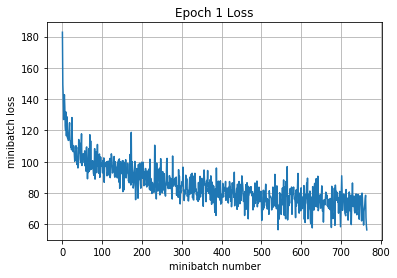

Iteration 800: with minibatch training loss = 1.28 and accuracy of 0.55
Iteration 1000: with minibatch training loss = 1.18 and accuracy of 0.61
Iteration 1200: with minibatch training loss = 0.961 and accuracy of 0.67
Iteration 1400: with minibatch training loss = 1.04 and accuracy of 0.64
Epoch 2, Overall loss = 1.01 and accuracy of 0.665


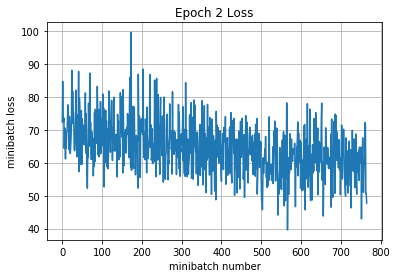

Iteration 1600: with minibatch training loss = 0.811 and accuracy of 0.75
Iteration 1800: with minibatch training loss = 0.805 and accuracy of 0.81
Iteration 2000: with minibatch training loss = 0.851 and accuracy of 0.72
Iteration 2200: with minibatch training loss = 0.779 and accuracy of 0.72
Epoch 3, Overall loss = 0.849 and accuracy of 0.717


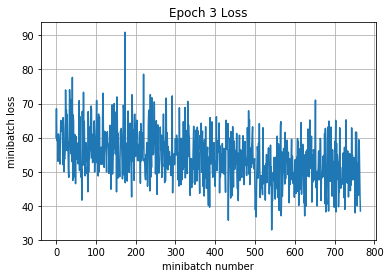

Iteration 2400: with minibatch training loss = 0.919 and accuracy of 0.66
Iteration 2600: with minibatch training loss = 0.761 and accuracy of 0.8
Iteration 2800: with minibatch training loss = 0.641 and accuracy of 0.81
Iteration 3000: with minibatch training loss = 0.763 and accuracy of 0.73
Epoch 4, Overall loss = 0.715 and accuracy of 0.767


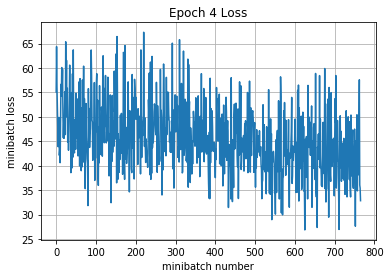

Iteration 3200: with minibatch training loss = 0.652 and accuracy of 0.73
Iteration 3400: with minibatch training loss = 0.636 and accuracy of 0.83
Iteration 3600: with minibatch training loss = 0.499 and accuracy of 0.83
Iteration 3800: with minibatch training loss = 0.581 and accuracy of 0.8
Epoch 5, Overall loss = 0.593 and accuracy of 0.81


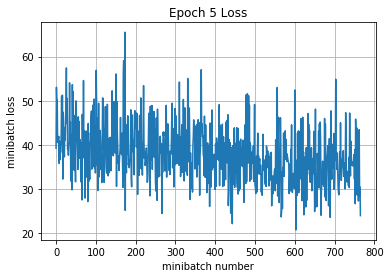

Iteration 4000: with minibatch training loss = 0.763 and accuracy of 0.73
Iteration 4200: with minibatch training loss = 0.429 and accuracy of 0.89
Iteration 4400: with minibatch training loss = 0.422 and accuracy of 0.89
Epoch 6, Overall loss = 0.481 and accuracy of 0.852


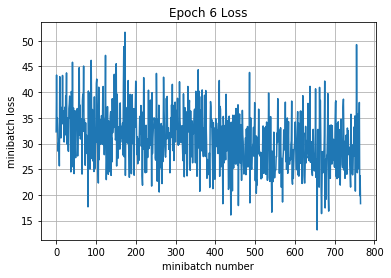

Iteration 4600: with minibatch training loss = 0.404 and accuracy of 0.91
Iteration 4800: with minibatch training loss = 0.394 and accuracy of 0.91
Iteration 5000: with minibatch training loss = 0.444 and accuracy of 0.91
Iteration 5200: with minibatch training loss = 0.408 and accuracy of 0.81
Epoch 7, Overall loss = 0.388 and accuracy of 0.884


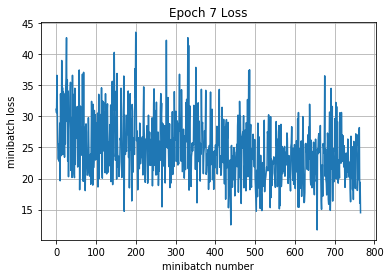

Iteration 5400: with minibatch training loss = 0.391 and accuracy of 0.88
Iteration 5600: with minibatch training loss = 0.296 and accuracy of 0.91
Iteration 5800: with minibatch training loss = 0.279 and accuracy of 0.92
Iteration 6000: with minibatch training loss = 0.314 and accuracy of 0.88
Epoch 8, Overall loss = 0.315 and accuracy of 0.907


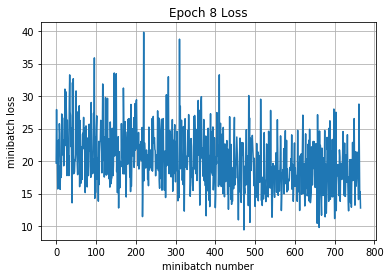

Iteration 6200: with minibatch training loss = 0.264 and accuracy of 0.89
Iteration 6400: with minibatch training loss = 0.462 and accuracy of 0.86
Iteration 6600: with minibatch training loss = 0.178 and accuracy of 0.97
Iteration 6800: with minibatch training loss = 0.156 and accuracy of 0.97
Epoch 9, Overall loss = 0.255 and accuracy of 0.928


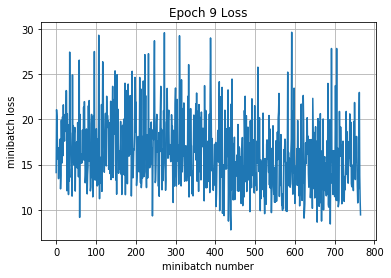

Iteration 7000: with minibatch training loss = 0.194 and accuracy of 0.94
Iteration 7200: with minibatch training loss = 0.236 and accuracy of 0.92
Iteration 7400: with minibatch training loss = 0.208 and accuracy of 0.98
Iteration 7600: with minibatch training loss = 0.173 and accuracy of 0.97
Epoch 10, Overall loss = 0.215 and accuracy of 0.94


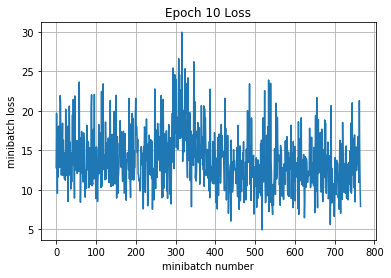

Validation
Epoch 1, Overall loss = 0.933 and accuracy of 0.719


In [27]:
# train with 10 epochs
sess = tf.Session()

try:
    with tf.device("/cpu:0") as dev:
        sess.run(tf.global_variables_initializer())
        print('Training')
        net.run(sess, mean_loss, X_train, y_train, 10, 64, 200, train_step, True)
        print('Validation')
        net.run(sess, mean_loss, X_val, y_val, 1, 64)
except tf.errors.InvalidArgumentError:
    print("no gpu found, please use Google Cloud if you want GPU acceleration") 

In [28]:
# view net model result on train  and validation set
print('Training')
net.run(sess, mean_loss, X_train, y_train, 1, 64)
print('Validation')
net.run(sess, mean_loss, X_val, y_val, 1, 64)

Training
Epoch 1, Overall loss = 0.148 and accuracy of 0.963
Validation
Epoch 1, Overall loss = 0.933 and accuracy of 0.719


(0.9328133769035339, 0.719)

In [29]:
# check result on test
print('Test')
net.run(sess, mean_loss, X_test, y_test, 1, 64)

Test
Epoch 1, Overall loss = 0.931 and accuracy of 0.717


(0.931040489578247, 0.717)

In [30]:
# create a feed dictionary for this batch
feed_dict = {X: X_test,
             y: y_test,
             is_training: False}

# predict
predict = sess.run(tf.nn.softmax(net.predict), feed_dict=feed_dict)
predict_df = pd.DataFrame(predict, columns=classes)

In [31]:
predict_df.head()

,plane,car,bird,cat,deer,dog,frog,horse,ship,truck
0,0.066759,0.000934,0.002122,0.862768,0.002302,0.061863,0.000405,7.952849e-05,0.000846,0.001922
1,0.006421,0.588468,0.000236,0.000088,0.000008,0.000430,0.000007,7.617688e-05,0.404255,0.000010
2,0.319594,0.023141,0.012414,0.015999,0.007489,0.003358,0.005441,1.029239e-02,0.584215,0.018056
3,0.923006,0.009561,0.004853,0.003019,0.002300,0.001382,0.002249,5.837278e-04,0.049255,0.003791
4,0.000019,0.000179,0.007419,0.015952,0.779520,0.000032,0.196573,9.670345e-07,0.000032,0.000272
